# Oscilador Duffing. Rodrigo Vega Vilchis



### 2. Estudie el Oscilador Duffing

A partir de la ecuación de segundo orden:

$$\ddot{x}+\delta\dot{x}-\omega_0^2x+\beta x^3=F_0\cos(\omega t)$$

#### 1. Construya el sistema 2D asociado

Realizando el mismo procedimiento que en el péndulo simple y el péndulo doble, se tiene que el sistema 2D asociado es igual a

$$
\begin{cases}
\dot{x}&=v\\
\dot{v}&=F_0\cos(\omega t)-\delta\dot{x}+\omega_0^2x-\beta x^3
\end{cases}
$$

#### 2. Para el caso $\delta=0$, $\omega_0^2=1$ y $F_0=0$. Calcule analíticamente sus puntos de equilibrio y encuentre su estabilidad (linealizando el sistema) y muestre numéricamente el plano fase así como la cruva solución ($x$ $vs$ $t$).

El sistema bajo las condiciones del problema lo podemos reescribir como sigue

$$
\begin{cases}
\dot{x}&=v\\
\dot{v}&=x-\beta x^3
\end{cases}
$$

Para calcular sus puntos de equilibrio hay que igualar a cero el sistema, sabemos que para $v=0$, existe un punto de equilibrio siempre. Luego de la ecuación 

$$
x-\beta x^3=0
$$

tenemos los puntos de equilibrio: $x_1=0$, $x_2=\frac{1}{\sqrt{b}}$ y $x_3=-\frac{1}{\sqrt{b}}$. Entonces tenemos los siguientes puntos de equilibrio

$$
\begin{cases}
E_1=(0,0)\\
E_2=(\frac{1}{\sqrt{b}},0)\\
E_3=(-\frac{1}{\sqrt{b}},0)
\end{cases}
$$

Linealizando el sistema necesitamos aplicar el jacobiano a nuestro sistema.

\begin{align*}
\mathbb{J}&=\begin{pmatrix}
\frac{\partial\dot{x}}{\partial x} & \frac{\partial\dot{x}}{\partial v}\\
\frac{\partial\dot{v}}{\partial x} & \frac{\partial\dot{v}}{\partial v}
\end{pmatrix}\\
&=\begin{pmatrix}
0 & 1\\
1-2\beta x^2 & 0
\end{pmatrix}
\end{align*}

Evaluando los puntos críticos en el Jacobiano tenemos

\begin{align*}
\mathbb{J}\ \bigg |_{E_1=(0,0)}&=\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}\\
\mathbb{J}\ \bigg |_{E_2=(\frac{1}{\sqrt{b}},0)}&=\begin{pmatrix}
0 & 1\\
-1 & 0
\end{pmatrix}\\
&=J\ \bigg|_{E_3=(-\frac{1}{\sqrt{b}},0)}
\end{align*}

Llegando a este punto ya podemos conocer la estabilidad del sistema con base en los eigenvalores de cada matriz Jacobiana. Los eigenvalores para la primera matriz Jacobiana son $\lambda_1\pm 1$, mientras que para las otras dos matrices son $\lambda_{2,3}=\pm i$. Notemos que tenemos dos centros en $E_2$ y $E_3$, mientras que tenemos un punto silla en $E_1$. Vamos a comprobarlo usando código y observando sus espacios fase.


In [1]:
using LinearAlgebra
using PyPlot

using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/rockdrigo6/anaconda3/lib/python3.8/site-packages/numpy/__init__.py'>

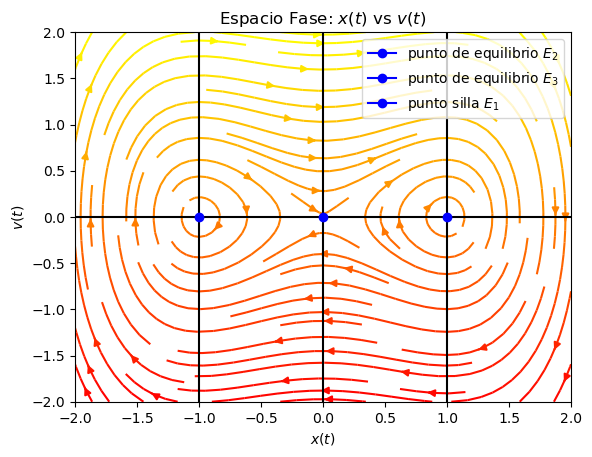

PyObject <matplotlib.legend.Legend object at 0x7f2c094e6ca0>

In [2]:
#Espacio fase del oscilador de Duffing considerando F0=0, δ=0 y ω0²=1
xs = collect(-2:0.1:2)
ys = collect(-2:0.1:2)
β = 1
X,Y = np.meshgrid(xs,ys)

U = Y
V = X - β*X.*X.*X
plt.title(L"Espacio Fase: $x(t)$ vs $v(t)$")
plt.axhline(0,color="black")
plt.axvline(1,color="black")
plt.axvline(-1,color="black")
plt.axvline(0,color="black")
plt.streamplot(xs,ys,U,V,color=U, cmap=plt.cm.autumn)
plt.xlabel(L"$x(t)$")
plt.ylabel(L"$v(t)$")
plt.plot(1,0, marker="o", color="blue",label = L"punto de equilibrio $E_2$")
plt.plot(-1,0, marker="o", color="blue",label = L"punto de equilibrio $E_3$")
plt.plot(0,0, marker="o", color="blue",label = L"punto silla $E_1$")
plt.legend(loc = "upper right")

El espacio fase confirma nuestros cálculos analíticos. Ahora pasemos a ver la evolución del péndulo bajo las condiciones del ejercicio. Para ello, yo emplearé el método de Runge-Kutta 4 que he estado utilizando en mis otras tareas, el cual presento a continuación.

In [3]:
"""Runge-Kutta 4. La función recibe como parámetros una función f(x), una condición inicial, un tiempo inicial
un tiempo final y un paso de integración, igual que el integrador de Euler"""

function RK4(f,x0,t0,tf,h)
    #=al igual que en la función de eulerND, definimos una matriz de dimensión 
    (número de iteraciones × dimensión del sistema dinámico) como conjunto solución=#
    t = range(t0, stop = tf, step = h)
    n = length(t)
    dim = length(x0)
    #lo hacemos en un arreglo de ceros
    xs = zeros(n,dim)
    #imponemos la condición inicial en el primer renglón
    xs[1,:] = x0
    #generamos un ciclo for con las iteraciones de runge-kutta de cuarto orden
    for i in  2:n
        k1 = f(xs[i-1,:])
        k2 = f(xs[i-1,:]+(h/2)*k1)
        k3 = f(xs[i-1,:]+(h/2)*k2)
        k4 = f(xs[i-1,:]+h*k3)
        
        xs[i,:] = xs[i-1,:] + (h/6)*(k1+2*k2+2*k3+k4)
    end
    #=regresamos el resultado en una tupla, con los tiempos en la primera entrada y 
    el conjunto solución en la segunda entrada=#
    return (t , xs)
end

RK4 (generic function with 1 method)

In [4]:
#Definimos el sistema del oscilador de Duffing en esta celda
function osciladorDuffingSimp(β,x0,t0,tf,h)
    #x0 es la condición inicial dada en un arreglo 2-dimensional para este caso
    #definimos el sistema
    function sistema(X)
        #X es un vector 2-dimensional también el cual fungirá el papel del sistema
        #X[1] equivale a la entrada x y X[2] a la entrada v
        return [X[2] , X[1] - β*X[1]^3]
    end
    #Resolvemos el sistema con Runge-Kutta
    return RK4(sistema,x0,t0,tf,h)
end

osciladorDuffingSimp (generic function with 1 method)

In [5]:
β = 1
x0 = [1,1]
t0 = 0.
tf = 50.
h = 0.01
tiempos, solDS = osciladorDuffingSimp(β,x0,t0,tf,h)

(0.0:0.01:50.0, [1.0 1.0; 1.0099996641625 0.9998989992298137; … ; 1.096674200200822 -0.9896754557909966; 1.0867667589122016 -0.9917702737369637])

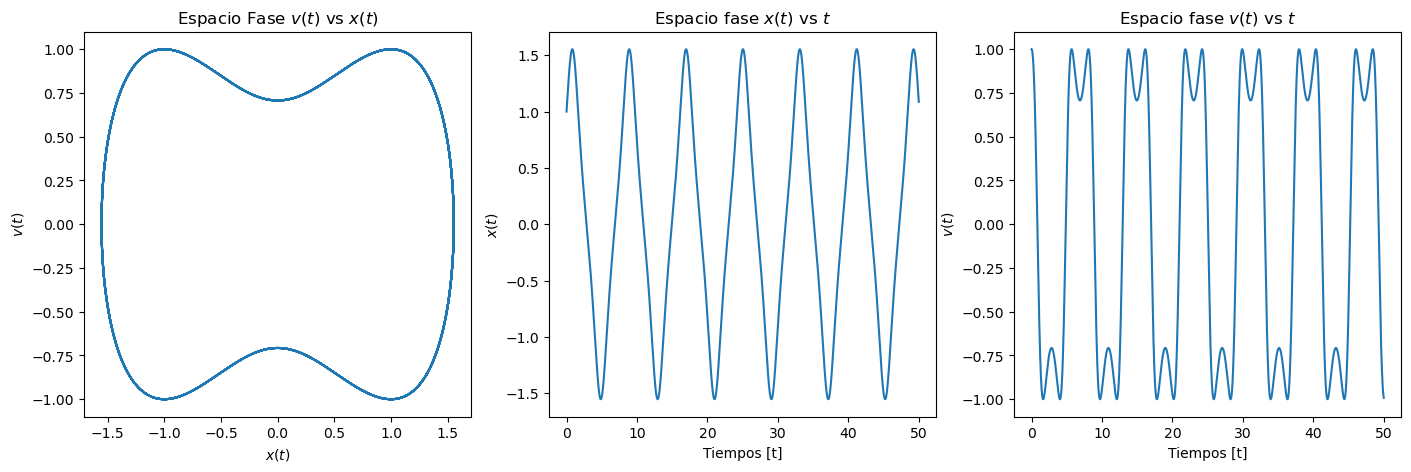

PyObject Text(956.0000000000001, 0.5, '$v(t)$')

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 3, figsize = (17,5))
ax1.plot(solDS[:,1],solDS[:,2])
ax1.set_title(L"Espacio Fase $v(t)$ vs $x(t)$")
ax1.set_xlabel(L"x(t)")
ax1.set_ylabel(L"v(t)")


ax2.plot(tiempos,solDS[:,1])
ax2.set_title(L"Espacio fase $x(t)$ vs $t$")
ax2.set_xlabel("Tiempos [t]")
ax2.set_ylabel(L"x(t)")

ax3.plot(tiempos,solDS[:,2])
ax3.set_title(L"Espacio fase $v(t)$ vs $t$")
ax3.set_xlabel("Tiempos [t]")
ax3.set_ylabel(L"v(t)")

Nuestra solución se confirma a lo que se tenía previsto del espacio fase mostrado hace unas celdas anteriores. Además de que de acuerdo a la gráfica de la posición, tiene una gráfica muy parecida a la del péndulo simple sin rozamiento; sus oscilaciones no decrecen como en un péndulo amortiguado.

#### 3. Para el caso $\delta=0.2$, $\omega_0^2=1$ y $F_0=0$ muestre numéricamente el plano fase así como la curva solución ($x\ vs\ t$). ¿Qué ocurre con respecto al caso anterior?

Para esta parte únicamente necesitamos modificar un poco el código anterior para ver que ocurre con las gráficas antes puestas. Sin embargo tenemos un nuevo sistema de ecuaciones el cual se decribe a continuación

$$
\begin{cases}
\dot{x}&=v\\
\dot{v}&=-0.2v+x-\beta x^3
\end{cases}
$$

Por tanto tenemos que modificar las ecuaciones en nuetra función `osciladorDuffingSimp`

In [7]:
#Modificacion de la función plasmada en celdas anteriores.
function osciladorDuffingVar02(β,x0,t0,tf,h)
    #x0 es la condición inicial dada en un arreglo 2-dimensional para este caso
    #definimos el sistema
    function sistema(X)
        #X es un vector 2-dimensional también el cual fungirá el papel del sistema
        #X[1] equivale a la entrada x y X[2] a la entrada v
        return [X[2] , -0.2*X[2] + X[1] - β*X[1]^3]
    end
    #Resolvemos el sistema con Runge-Kutta
    return RK4(sistema,x0,t0,tf,h)
end

osciladorDuffingVar02 (generic function with 1 method)

In [8]:
#Escogemos las mismas condiciones que en el ejercicio anterior, variando solo en el sistema de ecuaciones
β = 1
x0 = [1,1]
t0 = 0.
tf = 50.
h = 0.01
tiempos, solDSvar = osciladorDuffingVar02(β,x0,t0,tf,h)

(0.0:0.01:50.0, [1.0 1.0; 1.0099896711629237 0.9979011331350013; … ; 1.0055147124700796 -0.01191598865717017; 1.0053951200359783 -0.012002064295987401])

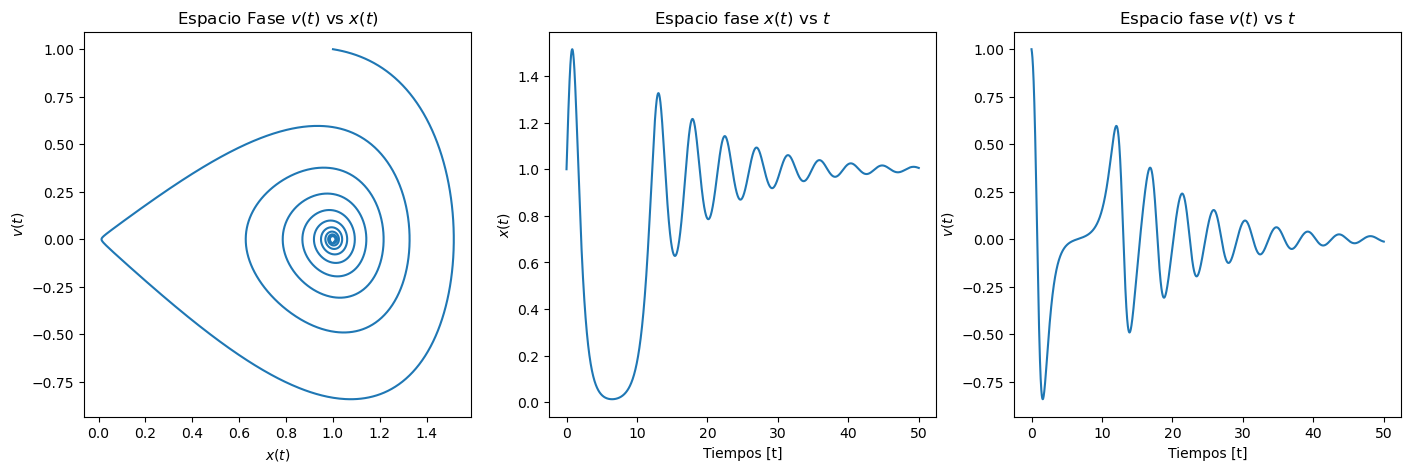

PyObject Text(956.0000000000001, 0.5, '$v(t)$')

In [9]:
fig, (ax4,ax5,ax6) = plt.subplots(ncols = 3, figsize = (17,5))
ax4.plot(solDSvar[:,1],solDSvar[:,2])
ax4.set_title(L"Espacio Fase $v(t)$ vs $x(t)$")
ax4.set_xlabel(L"x(t)")
ax4.set_ylabel(L"v(t)")

ax5.plot(tiempos,solDSvar[:,1])
ax5.set_title(L"Espacio fase $x(t)$ vs $t$")
ax5.set_xlabel("Tiempos [t]")
ax5.set_ylabel(L"x(t)")

ax6.plot(tiempos,solDSvar[:,2])
ax6.set_title(L"Espacio fase $v(t)$ vs $t$")
ax6.set_xlabel("Tiempos [t]")
ax6.set_ylabel(L"v(t)")

El cambio es completamente abismal tan solo con introducir una pequeña porción de la variable de la velocidad en la segunda ecuación. Es sumamente interesante, me causa curiosidad saber como es todo el espacio fase por lo que lo graficaré a continuación. Para este caso, también podemos notar en las evoluciones de la posición y velocidad como van decreciendo hasta llegar a su punto de equilibrio descrito en el espacio fase. Este ejemplo es lo más parecido a un oscilador armónicp amortiguado.

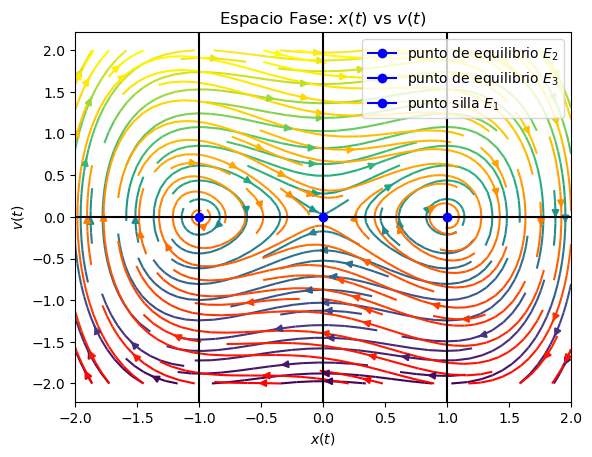

PyObject <matplotlib.legend.Legend object at 0x7f2c300f0c40>

In [10]:
#Espacio fase del oscilador de Duffing considerando F0=0, δ=0 y ω0²=1
xs = collect(-2:0.1:2)
ys = collect(-2:0.1:2)
β = 1
X,Y = np.meshgrid(xs,ys)

U = Y
V = X - β*X.*X.*X
plt.title(L"Espacio Fase: $x(t)$ vs $v(t)$")
plt.axhline(0,color="black")
plt.axvline(1,color="black")
plt.axvline(-1,color="black")
plt.axvline(0,color="black")
plt.streamplot(xs,ys,U,V,color=U, cmap=plt.cm.viridis)
plt.xlabel(L"$x(t)$")
plt.ylabel(L"$v(t)$")
plt.plot(1,0, marker="o", color="blue",label = L"punto de equilibrio $E_2$")
plt.plot(-1,0, marker="o", color="blue",label = L"punto de equilibrio $E_3$")
plt.plot(0,0, marker="o", color="blue",label = L"punto silla $E_1$")
plt.legend(loc = "upper right")



#Espacio fase del oscilador de Duffing considerando F0=0, δ=0.2 y ω0²=1
xs = collect(-2:0.1:2)
ys = collect(-2:0.1:2)
β = 1
X,Y = np.meshgrid(xs,ys)

U = Y
V = -0.2*Y + X - β*X.*X.*X
plt.title(L"Espacio Fase: $x(t)$ vs $v(t)$")
plt.streamplot(xs,ys,U,V,color=U, cmap=plt.cm.autumn)
plt.xlabel(L"$x(t)$")
plt.ylabel(L"$v(t)$")
plt.legend(loc = "upper right")

En esta figura he superpuesto los espacios fase obtenidos hasta ahora, todo parece indicar que tienen los mismos puntos de equilibrio, pero cambia su dinámica, pues se nota que ambas lineas del espacio fase no coinciden exactamente, sino solo son similares. En cambio, en las series de tiempo es muy interesante el resultado, pues en el espacio fase ya solamente nos muestra uno de los dos centros; las evoluciones de la posición y de la velocidad son completamente distintos ante ese pequeño cambio, muestra como un comportamiento caótico frente a una peuqeña variación del sistema.

##### 4. (Extra). Para el caso $\delta=0.2$, $\omega_0^2=1$ y $F_0=0.3$ muestre numéricamente el plano fase así como la curva solución ($x\ vs\ t$). ¿Qué ocurre respecto al caso anterior? Para este caso, estudie que tan sensible es la solución a condiciones iniciales. Para esto, compare dos trayectorias solución cercanas $S$ y $S_\epsilon$, la primera iniciando desde algún punto $(x_0,y_0)$ y la segunda desde $(x_0+\epsilon,y_0+\epsilon)$ y observe si a largo plazo terminan en lugares cercanos. Describa cuál es su opinión con respecto de este comportamiento.

Para lograr este cometido, necesitamos introducir un método de Runge-Kutta dependiente del tiempo, para ello solo hay que realizar un ligero ajuste en las ecuaciones y todo quedará listo.

In [11]:
"""Runge-Kutta 4 dependiente del tiempo. La función recibe como parámetros una función f(x,t),
una condición inicial, un tiempo inicial un tiempo final y un paso de integración,
igual que el integrador de Euler"""

"""la función que ahora recibe RF4 es dependiente del tiempo también"""
function RK4Temporal(f,x0,t0,tf,h)
    #=al igual que en la función de eulerND, definimos una matriz de dimensión 
    (número de iteraciones × dimensión del sistema dinámico) como conjunto solución=#
    t = range(t0, stop = tf, step = h)
    n = length(t)
    dim = length(x0)
    #lo hacemos en un arreglo de ceros
    xs = zeros(n,dim)
    #imponemos la condición inicial en el primer renglón
    xs[1,:] = x0
    #generamos un ciclo for con las iteraciones de runge-kutta de cuarto orden
    """Actualizamos el método agregando una componente temporal al método"""
    for i in  2:n
        k1 = f(xs[i-1,:],t[i-1])
        k2 = f(xs[i-1,:]+(h/2)*k1,t[i-1]+h/2)
        k3 = f(xs[i-1,:]+(h/2)*k2,t[i-1]+h/2)
        k4 = f(xs[i-1,:]+h*k3,t[i-1]+h)
        
        xs[i,:] = xs[i-1,:] + (h/6)*(k1+2*k2+2*k3+k4)
    end
    #=regresamos el resultado en una tupla, con los tiempos en la primera entrada y 
    el conjunto solución en la segunda entrada=#
    return (t , xs)
end

RK4Temporal

In [12]:
#Modificacion de la función plasmada en celdas anteriores, agregando dependencia temporal
function osciladorDuffing(β,x0,t0,tf,h)
    #x0 es la condición inicial dada en un arreglo 2-dimensional para este caso
    #definimos el sistema
    function sistema(X,t)
        #X es un vector 2-dimensional también el cual fungirá el papel del sistema
        #X[1] equivale a la entrada x y X[2] a la entrada v
        return [X[2] , 0.3*cos(t) - 0.2*X[2] + X[1] - β*X[1]^3]
    end
    #Resolvemos el sistema con Runge-Kutta
    return RK4Temporal(sistema,x0,t0,tf,h)
end

osciladorDuffing (generic function with 1 method)

In [13]:
#Escogemos las mismas condiciones que en el ejercicio anterior, variando solo en el sistema de ecuaciones
β = 1
x0 = [1,1]
t0 = 0.
tf = 50.
h = 0.01
tiempos, solD = osciladorDuffing(β,x0,t0,tf,h)

(0.0:0.01:50.0, [1.0 1.0; 1.0100046607892281 1.00089798300342; … ; -0.8392645024962444 -0.5655904230552282; -0.8449126083875382 -0.5640193307107566])

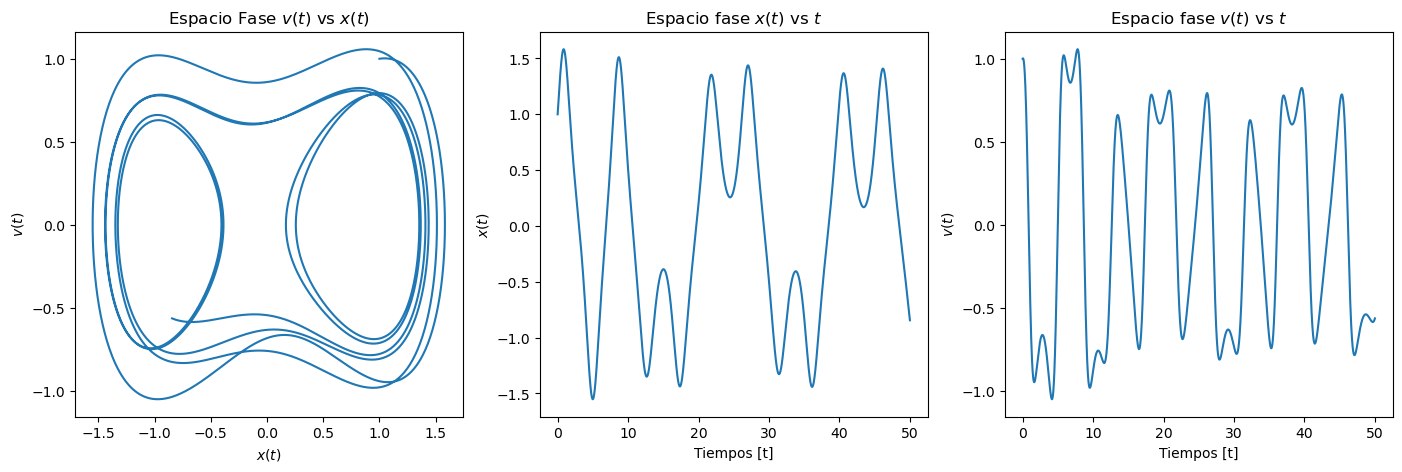

PyObject Text(956.0000000000001, 0.5, '$v(t)$')

In [14]:
fig, (ax7,ax8,ax9) = plt.subplots(ncols = 3, figsize = (17,5))
ax7.plot(solD[:,1],solD[:,2])
ax7.set_title(L"Espacio Fase $v(t)$ vs $x(t)$")
ax7.set_xlabel(L"x(t)")
ax7.set_ylabel(L"v(t)")

ax8.plot(tiempos,solD[:,1])
ax8.set_title(L"Espacio fase $x(t)$ vs $t$")
ax8.set_xlabel("Tiempos [t]")
ax8.set_ylabel(L"x(t)")

ax9.plot(tiempos,solD[:,2])
ax9.set_title(L"Espacio fase $v(t)$ vs $t$")
ax9.set_xlabel("Tiempos [t]")
ax9.set_ylabel(L"v(t)")

Este caso es el mas interesante de los tres, definitivamente tiene más parecido con el primer caso que con se segundo, no hay pérdida de energía por fricción debido a la fuerza periódica dependiente del tiempo que se le esta suministrando ($F_0$). También podemos ver como parece que comparte los mismos puntos de equilibrio comparado con el primer caso; sin embargo la posición muestra oscilaciones raras que son muestra de dicha fuerza externa que esta ayudando al oscilador a no perder energía. Veamos ahora que tan sensible es el sistema con respecto de sus condiciones iniciales. De entrada las variaré 0.1 unidades.

In [15]:
#Mismas condiciones que antes solo que variando 0.1 en las condiciones iniciales
β = 1
x0 = [1 + 0.01 , 1 + 0.01]
t0 = 0.
tf = 50.
h = 0.01
tiempos, solDϵ = osciladorDuffing(β,x0,t0,tf,h)

(0.0:0.01:50.0, [1.01 1.01; 1.0201035329461827 1.010671129974491; … ; 0.3786443857159854 0.3911208914019743; 0.382582368475947 0.39647892142502844])

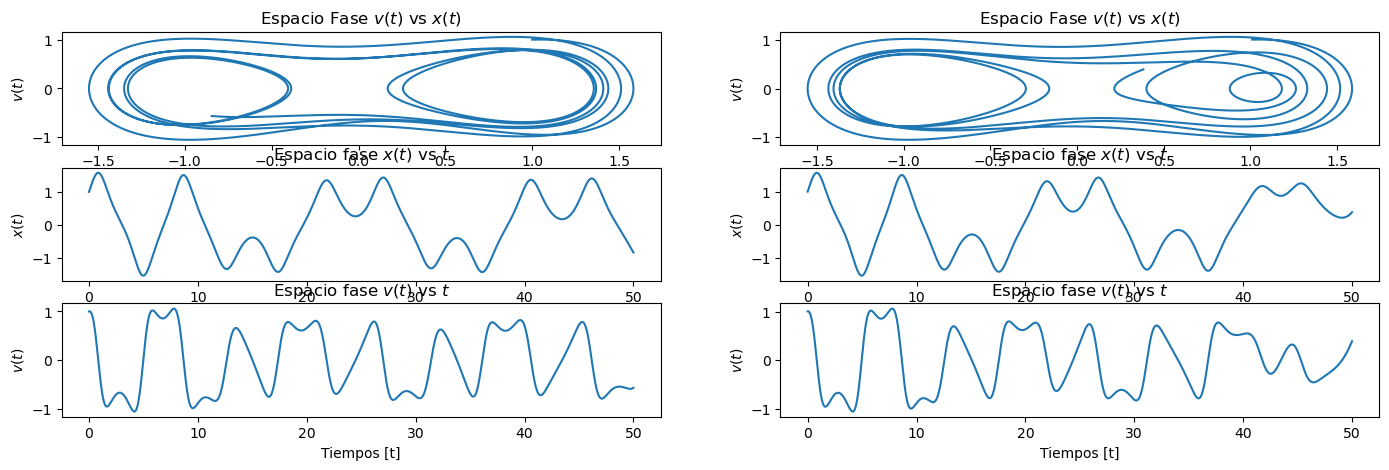

PyObject Text(744.6363636363634, 0.5, '$v(t)$')

In [16]:
fig, (ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(3,2, figsize = (17,5))
ax7.plot(solD[:,1],solD[:,2])
ax7.set_title(L"Espacio Fase $v(t)$ vs $x(t)$")
ax7.set_xlabel(L"x(t)")
ax7.set_ylabel(L"v(t)")

ax8.plot(tiempos,solD[:,1])
ax8.set_title(L"Espacio fase $x(t)$ vs $t$")
ax8.set_xlabel("Tiempos [t]")
ax8.set_ylabel(L"x(t)")

ax9.plot(tiempos,solD[:,2])
ax9.set_title(L"Espacio fase $v(t)$ vs $t$")
ax9.set_xlabel("Tiempos [t]")
ax9.set_ylabel(L"v(t)")

ax10.plot(solDϵ[:,1],solDϵ[:,2])
ax10.set_title(L"Espacio Fase $v(t)$ vs $x(t)$")
ax10.set_xlabel(L"x(t)")
ax10.set_ylabel(L"v(t)")

ax11.plot(tiempos,solDϵ[:,1])
ax11.set_title(L"Espacio fase $x(t)$ vs $t$")
ax11.set_xlabel("Tiempos [t]")
ax11.set_ylabel(L"x(t)")

ax12.plot(tiempos,solDϵ[:,2])
ax12.set_title(L"Espacio fase $v(t)$ vs $t$")
ax12.set_xlabel("Tiempos [t]")
ax12.set_ylabel(L"v(t)")

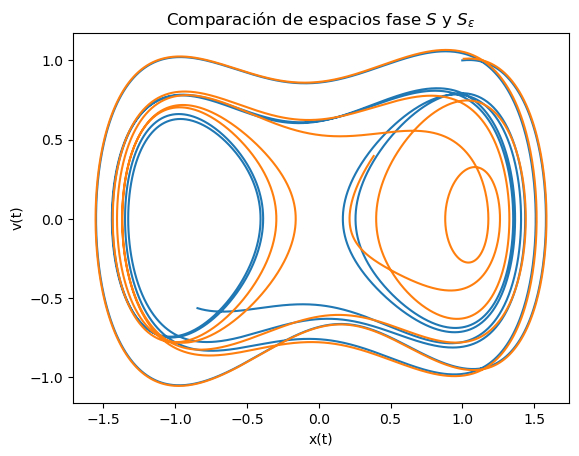

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2c0845aca0>

In [17]:
plt.plot(solD[:,1],solD[:,2])
plt.title(L"Comparación de espacios fase $S$ y $S_\epsilon$")
plt.xlabel("x(t)")
plt.ylabel("v(t)")

plt.plot(solDϵ[:,1],solDϵ[:,2])


Podemos notar que apenas con una variación de 0.01 en cada una de las entradas de las condiciones iniciales se tiene un gran cambio en el espacio fase. Sin embargo para las series de tiempo comienzan a haber trayectorias evoluciones diferentes a partir de $t\approx 10$. Un detalle muy **curioso** que me llamó la atención es que al realizar una variación de 0.1, parece que **no existe cambio en los espacios fase y en las series de tiempo**, veamoslo a continuación

In [18]:
β = 1
x0 = [1 + 0.1 , 1 + 0.1]
t0 = 0.
tf = 50.
h = 0.01
tiempos, solDϵ01 = osciladorDuffing(β,x0,t0,tf,h)

(0.0:0.01:50.0, [1.1 1.1; 1.1109919698166766 1.0983456425208076; … ; -0.7771058014960744 0.36844012577877033; -0.7734260740216283 0.3675020923796077])

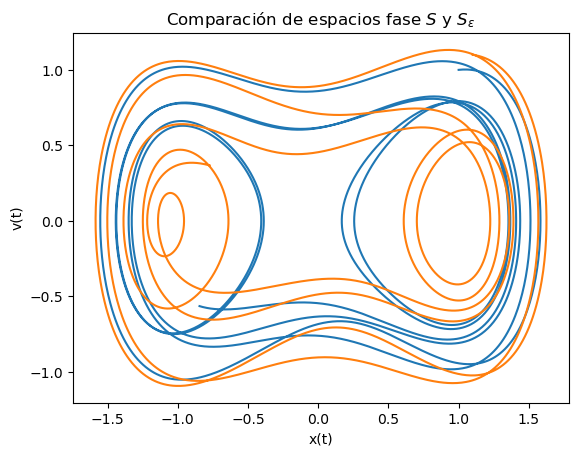

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2c301283d0>

In [19]:
plt.plot(solD[:,1],solD[:,2])
plt.title(L"Comparación de espacios fase $S$ y $S_\epsilon$")
plt.xlabel("x(t)")
plt.ylabel("v(t)")

plt.plot(solDϵ01[:,1],solDϵ01[:,2])

Las gráficas parece que estan perfectamente superpuestas, quizás se trate de un punto de estabilidad dentro de todas las variaciones caóticas. Las series de tiempo son las siguientes.

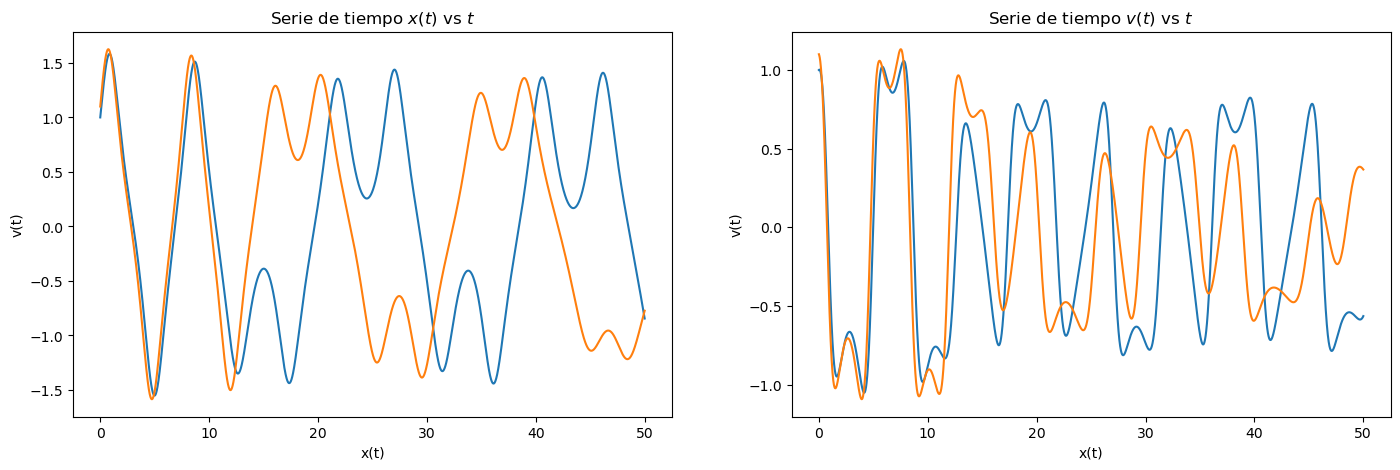

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2c07776b50>

In [20]:
fig, (ax13,ax14) = plt.subplots(ncols = 2, figsize = (17,5))

ax13.plot(tiempos,solD[:,1])
ax13.set_title(L"Serie de tiempo $x(t)$ vs $t$")
ax13.set_xlabel("x(t)")
ax13.set_ylabel("v(t)")
ax13.plot(tiempos,solDϵ01[:,1])

ax14.plot(tiempos,solD[:,2])
ax14.set_title(L"Serie de tiempo $v(t)$ vs $t$")
ax14.set_xlabel("x(t)")
ax14.set_ylabel("v(t)")
ax14.plot(tiempos,solDϵ01[:,2])

Sin duda esto es muy interesante y me pareció prudente incluirlo en esta parte final del ejercicio. Las conclusiones son de que aún para pequeñas variaciones en las conidiciones iniciales para este caso, tenemos una evolución temporal distinta excepto como vimo para $\epsilon=0.1$. 

El primer caso del ejercicio corresponde a un oscilador armónico simple, o al menos se le parece. El segundo caso corresponde a un oscilador armónico amortiguado ya que en el espacio fase tenemos un sumidero y las series de tiempo convergen al punto de equilibrio. El tercer caso corresponde a un oscilador armónico con oscilaciones forzadas, tenemos una fuerza externa que le brinda energía al sistema.